#### hello maize
- Maizeを実際に使ってみましょう
- 以下のコードはExampleというノードを2つワークフローに追加し最後にそれをConcatするという例です。
- オリジナルのノードはNodeクラスを継承することで作成できます。
- ワークフローはpythonでプログラム的に定義することもできるし（最も柔軟なアプローチ）、ツリーベースのシリアライゼーションフォーマット（JSON、YAML、TOML）で記述することもできます。
- その後、python内で実行したり、コマンドラインツールとして公開して他のパイプラインに統合したりすることができます。
- airflow*や*luigi*のようなパイプラインツールとは対照的に、maizeはサイクルや条件分岐を含む任意のトポロジーでワークフローを実行できます。

In [1]:
from maize.core.interface import Parameter, Output, MultiInput
from maize.core.node import Node
from maize.core.workflow import Workflow

### Node の説明
- Example
  - パラメータとして文字を受け取ります。デフォルトはHelloです。
  - アウトプットとして受け取ったデータをそのまま次のノードに渡します。
- ConcatAndPrint
  - ConcatAndPrintは名前の通り、複数の入力を受取り、それをループで回し . を区切りにしてジョイン、最後にLoggerのにConcatした文字を渡します。

In [5]:
class Example(Node):
    data: Parameter[str] = Parameter(default="Hello")
    out: Output[str] = Output()

    def run(self) -> Node:
        self.out.send(self.data.value)

class ConcatAndPrint(Node):
    inp: MultiInput[str] = MultiInput()

    def run(self):
        result = " ".join(inp.receive() for inp in self.inp)
        print("###########################")
        print(f"{result}")
        print("###########################")
        self.logger.info("Received: '%s'", result)



### WorlFlow の説明
- まず最初にWorkflowオブジェクトを作成します。
- 次いでワークフローにノードを追加します。Exampleノードは動作が異なるものを2つ足します。
- さらにConcatAndPrintノードを足します。
- 最後に各ノードの結合情報を付与します。

In [6]:
flow = Workflow(name='hello')
ex1 = flow.add(Example, name='ex1', parameters=dict(data='nice to meet you!'))
ex2 = flow.add(Example, name='ex2', parameters=dict(data='maize'))
concat = flow.add(ConcatAndPrint)
flow.connect(ex1.out, concat.inp)
flow.connect(ex2.out, concat.inp)
flow.check()

#### check and execute
- チェックで問題がない場合は実行プロセスを可視化してその後実行してみましょう。
- 実行プロセスはグラフで表現されます。Pipeline pilotやKnimeを利用されている方にとっては馴染みのある表現かと思います。

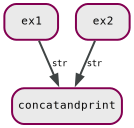

In [7]:
flow.visualize()

In [8]:
flow.execute()

2024-10-12 20:54:59,023 |     INFO |            hello | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-12 20:54:59,024 |     INFO |            hello | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-12 20:5

###########################
nice to meet you! maize
###########################


2024-10-12 20:54:59,852 |     INFO |            hello | Node 'concatandprint' finished (2/3)
2024-10-12 20:54:59,851 |     INFO |   concatandprint | Received: 'nice to meet you! maize'
2024-10-12 20:54:59,856 |     INFO |            hello | Node 'ex1' finished (3/3)
2024-10-12 20:55:00,358 |     INFO |            hello | Execution completed :) total runtime: 0:00:00.815766
	3 nodes completed successfully
	0 nodes stopped due to closing ports
	0 nodes failed
	0:00:01.028250 total walltime
	0:00:01.012892 spent waiting for resources or other nodes


### step1
- ワークフローの最初の一歩はworkflow objectを作ることです。
- levelはロギングの冗長性を指定し（pythonのloggingモジュールを参照）、 cleanup_tempは実行中に作成されたディレクトリをクリーンアップすべきかどうかを指定し、 default_channel_sizeは一度にノード間チャネルに置くことができるアイテムの数を決定し、 logfileはSTDOUTではなくファイルにログを書き込むことを許可します。
```python
from pathlib import Path
flow = Workflow(
   name="Example",
   level="debug",
   cleanup_temp=False,
   default_channel_size=5,
   logfile=Path("out.log")
)
```

- 作成したWorkflowにはNodeを適宜追加できます。
```python
node = flow.add(Example)
node2 = flow.add(Example, name="other_example")
```
- また様々なオプションを渡すことも可能です。
```python
other = flow.add(
   OtherExample,
   name="other",
   parameters=dict(value=42),
   loop=True,
   fail_ok=True,
   n_attempts=3,
   max_loops=5
)
```

#### step2
- ノードを追加したあとは各ノードをつなげましょう。
```python
flow.connect(node.output, other.input)
```

#### step3
- 全部準備ができたら実行します。
```python
flow.execute()
```

# Nodeを作ってみる-1
- カスタムノードを作る場合はNodeを継承して作成します。
- 以下の例では、入力としてStringを受取り、出力として受け取ったデータの値を返すという挙動を取ります。

In [9]:
class Example(Node):
    out: Output[str] = Output()
    data: Parameter[str] = Parameter(default="hello")

    def run(self) -> None:
        self.out.send(self.data.value)

- File IOのノードを見てみます。
- このノードではPathを受取り、ファイルの有無を確認し、Pathを次の処理に渡すという流れを担います。
 
```python
P = TypeVar("P", bound=Path)
class LoadFile(Node, Generic[P]):
    """Provides a file specified as a parameter on an output."""

    file: FileParameter[P] = FileParameter()
    """Path to the input file"""

    out: Output[P] = Output(mode="copy")
    """File output"""

    def run(self) -> None:
        path = self.file.filepath
        if not path.exists():
            raise FileNotFoundError(f"File at path {path.as_posix()} not found")

        self.out.send(path)
```


# Nodeを作ってみる-2
- カスタムノードではファイルの受け渡しもできます。
- 中間ファイルを出力しそれを次に渡すと行った処理を考える際に便利です。
- パラメータの型としてpathlib.Pathを指定しましょう。
- これはMaize-contribのSmilesのファイルを読むクラスのコードです。

```python
from typing import Annotated, Any, Callable, Iterable, List, Literal, TypeVar
from maize.core.node import Node
from maize.core.interface import Input, Output, Parameter, FileParameter, Suffix, Flag, MultiInput

class LoadSmiles(Node):
    """Load SMILES codes from a ``.smi`` file."""

    path: FileParameter[Annotated[Path, Suffix("smi")]] = FileParameter()
    """SMILES file input"""

    out: Output[list[str]] = Output()
    """SMILES output"""

    sample: Parameter[int] = Parameter(optional=True)
    """Take a sample of SMILES"""

    def run(self) -> None:
        with self.path.filepath.open() as file:
            smiles = [smi.strip("\n") for smi in file.readlines()]
            if self.sample.is_set:
                smiles = random.choices(smiles, k=self.sample.value)
            self.out.send(smiles)
```

- 上の例ではSmilesファイルを読むことに特化していましが、同じ要領でテキストファイルを読み込みそれをプリントするWFを書いてみましょう。
- データは../dataにあるのをデフォルトで利用していますが適宜変えてもらって構いません。

In [10]:
from typing import Annotated, Any, Callable, Iterable, List, Literal, TypeVar
from maize.core.node import Node
from maize.core.interface import Input, Output, Parameter, FileParameter, Suffix, Flag, MultiInput
from pathlib import Path

class LoadText(Node):
    path: FileParameter[Path] = FileParameter()
    out: Output[str] = Output()
    def run(self) -> None:
        with self.path.filepath.open() as file:
            text_data = "\n\n"+"".join([line for line in file.readlines()])+"\n\n"
            self.out.send(text_data)

class PrintTxt(Node):
    inp: Input[str] = Input()

    def run(self):
        result = self.inp.receive()
        self.logger.info("Received: '%s'", result)

In [11]:
flow = Workflow(
   name="file_handling",
   #level="debug",
   cleanup_temp=False,
   #logfile=Path("out.log")
)

In [12]:
filepath = Path("../data/loadfile_demo.txt")
load = flow.add(LoadText, parameters=dict(path=filepath))
printer = flow.add(PrintTxt)

In [13]:
flow.connect(load.out, printer.inp)

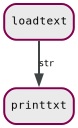

In [14]:
flow.check()
flow.visualize()

In [15]:
flow.execute()

2024-10-12 20:55:24,747 |     INFO |    file_handling | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-12 20:55:24,750 |     INFO |    file_handling | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-12 20:5

# 条件により分岐するワークフロー
- ノードの処理の結果によって分岐させたいことも可能です。
- 下の例ではLoadDataのパラメータ（Dataが10未満か、否か）によって処理を分岐させています。

In [17]:
from maize.core.node import Node
from maize.core.interface import Input, Output
from maize.core.workflow import Workflow
from maize.steps.io import LoadData, LogResult
from maize.steps.plumbing import Merge

class Condition(Node):
    inp: Input[int] = Input()
    out_a: Output[int] = Output()
    out_b: Output[int] = Output()

    def run(self) -> None:
        data = self.inp.receive()
        if data < 10:
            self.out_a.send(data)
        else:
            self.out_b.send(data)

In [18]:
flow = Workflow(name="cycle")
load = flow.add(LoadData[int], parameters={"data": 17})
cond = flow.add(Condition)
out_a = flow.add(LogResult, name="out_a")
out_b = flow.add(LogResult, name="out_b")
flow.connect_all(
    (load.out, cond.inp),
    (cond.out_a, out_a.inp),
    (cond.out_b, out_b.inp)
)

In [19]:
flow.check()

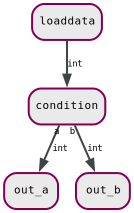

In [20]:
flow.visualize()

In [21]:
flow.execute()

2024-10-12 20:57:19,727 |     INFO |            cycle | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-12 20:57:19,729 |     INFO |            cycle | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-12 20:5

# 繰り返しを含むワークフロー
- Dealyは指定された秒数time.sleepによって処理を止めます
- Mergeは複数の入力を受取り、一つのポートからそれらを出力します。

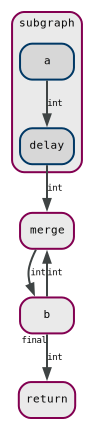

In [22]:
from maize.core.graph import Graph
from maize.core.interface import Parameter, Input, Output
from maize.core.node import Node
from maize.core.workflow import Workflow

from maize.steps.plumbing import Delay, Merge
from maize.steps.io import Return
from typing import TypeVar, Generic
T = TypeVar("T")

class A(Node):
    out: Output[int] = Output()
    send_val: Parameter[int] = Parameter()

    def run(self) -> None:
        self.out.send(self.send_val.value)


class B(Node):
    inp: Input[int] = Input()
    out: Output[int] = Output()
    final: Output[int] = Output()

    def run(self) -> None:
        val = self.inp.receive()
        if val > 48:
            self.logger.debug("%s stopping", self.name)
            self.final.send(val)
            return
        print(val+2)
        self.out.send(val + 2)

class SubGraph(Graph):
    
    def build(self) -> None:
        a = self.add(A, parameters=dict(send_val=36))
        d = self.add(Delay[int], parameters=dict(delay=1))
        self.connect(a.out, d.inp)
        #map_portを使いサブグラフの出力ポートを作成　普通のノードはself.out.send(xxx) etc
        self.out = self.map_port(d.out)
        self.val = self.combine_parameters(a.send_val, name="val")


flow = Workflow(name="test")
sg = flow.add(SubGraph)
b = flow.add(B, loop=True)
merge = flow.add(Merge[int])
ret = flow.add(Return[int])
flow.connect(sg.out, merge.inp)
flow.connect(merge.out, b.inp)
flow.connect(b.out, merge.inp)
flow.connect(b.final, ret.inp)
flow.combine_parameters(sg.val, name="val")
flow.check()
flow.visualize()

In [23]:
flow.execute()

2024-10-12 20:57:30,355 |     INFO |             test | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-12 20:57:30,358 |     INFO |             test | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-12 20:5

38
40


2024-10-12 20:57:34,992 |     INFO |             test | Workflow status
                                   |                b | WAITING_FOR_OUTPUT
                                   |            merge | RUNNING
                                   |                a | COMPLETED
                                   |           return | WAITING_FOR_INPUT
                                   |            delay | STOPPED


42
44


2024-10-12 20:57:37,018 |     INFO |             test | Workflow status
                                   |                b | RUNNING (0 | 1)
                                   |            merge | RUNNING
                                   |                a | COMPLETED
                                   |           return | WAITING_FOR_INPUT
                                   |            delay | STOPPED


46
48


2024-10-12 20:57:39,508 |     INFO |             test | Workflow status
                                   |                b | RUNNING (0 | 1)
                                   |            merge | WAITING_FOR_INPUT
                                   |                a | COMPLETED
                                   |           return | WAITING_FOR_INPUT
                                   |            delay | STOPPED


50


2024-10-12 20:57:40,548 |     INFO |             test | Node 'return' finished (3/5)
2024-10-12 20:57:41,050 |     INFO |             test | Node 'b' finished (4/5)
2024-10-12 20:57:41,514 |     INFO |             test | Node 'merge' finished (5/5)
2024-10-12 20:57:42,017 |     INFO |             test | Execution completed :) total runtime: 0:00:11.121632
	2 nodes completed successfully
	3 nodes stopped due to closing ports
	0 nodes failed
	0:00:33.541471 total walltime
	0:00:20.960689 spent waiting for resources or other nodes
